In [1]:
# IMPORTING LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

In [3]:
# IMPORTING THE DATA SET

In [4]:
# use the link in the project description on the website to find the dataset on Kaggle. It is too big to upload on GitHub
file_path = "/Users/lassewillen/Downloads/car_prices.csv"
car_data = pd.read_csv(file_path)
car_data.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)


In [5]:
car_data.describe().round()

,year,condition,odometer,mmr,sellingprice
count,558837.0,547017.0,558743.0,558799.0,558825.0
mean,2010.0,31.0,68320.0,13769.0,13611.0
std,4.0,13.0,53399.0,9680.0,9750.0
min,1982.0,1.0,1.0,25.0,1.0
25%,2007.0,23.0,28371.0,7100.0,6900.0
50%,2012.0,35.0,52254.0,12250.0,12100.0
75%,2013.0,42.0,99109.0,18300.0,18200.0
max,2015.0,49.0,999999.0,182000.0,230000.0


In [6]:
# DATA CLEANING

In [7]:
#dropping missing values 
# no duplicate removal as it is highly plausbile that duplicates exist in such a dataset
car_data.dropna(inplace=True)

In [8]:
car_data.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
dtype: int64

In [9]:
from datetime import datetime

# Step 1: Removing rows where 'make', 'model', or 'vin' is missing
car_data = car_data.dropna(subset=['make', 'model', 'vin'])

# Step 2: Converting 'saledate' to datetime format
car_data['saledate'] = pd.to_datetime(car_data['saledate'], errors='coerce')

# Step 3: Removing rows with missing values in 'odometer', 'mmr', and 'sellingprice'
car_data = car_data.dropna(subset=['odometer', 'mmr', 'sellingprice'])


/var/folders/k3/zy7bwjn17dbd2rp0jjzmcqt00000gn/T/ipykernel_33694/1339669037.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  car_data['saledate'] = pd.to_datetime(car_data['saledate'], errors='coerce')


In [10]:
# Further cleaning steps

# Normalizing textual data: Converting 'make', 'model', 'trim', 'body', 'color', and 'interior' to lowercase
text_columns = ['make', 'model', 'trim', 'body', 'color', 'interior']
car_data[text_columns] = car_data[text_columns].apply(lambda x: x.str.lower())

# Handling 'transmission' missing values by categorizing them as 'unknown'
car_data['transmission'] = car_data['transmission'].fillna('unknown')

# Imputing 'condition' missing values with the median of the 'condition' column
condition_median = car_data['condition'].median()
car_data['condition'] = car_data['condition'].fillna(condition_median)

# Final check on the current state of missing values after further cleaning
final_missing_values_summary = car_data.isnull().sum()

# Displaying the summary of cleaned data
final_cleaned_summary = {
    "Cleaned rows after further steps": car_data.shape[0],
    "Current missing values after further steps": final_missing_values_summary
}

final_cleaned_summary


{'Cleaned rows after further steps': 472325,
 'Current missing values after further steps': year            0
 make            0
 model           0
 trim            0
 body            0
 transmission    0
 vin             0
 state           0
 condition       0
 odometer        0
 color           0
 interior        0
 seller          0
 mmr             0
 sellingprice    0
 saledate        0
 dtype: int64}

In [11]:
# Import necessary libraries
from scipy import stats
# Define a function to detect and count outliers for each numerical column using the IQR method
def count_outliers_iqr(dataframe, columns):
    outlier_counts = {}
    for column in columns:
        q1 = dataframe[column].quantile(0.25)
        q3 = dataframe[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
        outlier_counts[column] = len(outliers)
    return outlier_counts

# List of numerical columns to check for outliers
numerical_columns = ['year', 'condition', 'odometer', 'mmr', 'sellingprice']

# Count outliers in each numerical column of car_data
outlier_counts = count_outliers_iqr(car_data, numerical_columns)

outlier_counts



{'year': 9799,
 'condition': 0,
 'odometer': 9029,
 'mmr': 14038,
 'sellingprice': 14118}

In [12]:
# Define a function to calculate the value range of outliers for each numerical column using the IQR method
def outlier_value_range(dataframe, columns):
    outlier_ranges = {}
    for column in columns:
        q1 = dataframe[column].quantile(0.25)
        q3 = dataframe[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
        if not outliers.empty:
            min_outlier = outliers[column].min()
            max_outlier = outliers[column].max()
        else:
            min_outlier = max_outlier = None
        outlier_ranges[column] = (min_outlier, max_outlier)
    return outlier_ranges

# Calculate the value range of outliers for each numerical column in car_data
outlier_value_ranges = outlier_value_range(car_data, numerical_columns)

outlier_value_ranges

{'year': (1990, 2000),
 'condition': (None, None),
 'odometer': (199272.0, 999999.0),
 'mmr': (34700.0, 182000.0),
 'sellingprice': (34750.0, 230000.0)}

In [13]:
# outliers are not ectreme instead of the odometers
# Set the threshold for extreme odometer readings. Delete these rows
odometer_threshold = 500000
# outliers for prices are okay, odometer is not realistic. Therefore delete rows with odometer ratings
# Correcting the DataFrame name to car_data and removing rows with odometer readings above the threshold
car_data = car_data[car_data['odometer'] <= odometer_threshold]

# Verify the correction by checking the shape of the cleaned dataset
car_data.shape


(472258, 16)

In [14]:
# SUPERVISED ALGORITHM

In [15]:
y = car_data['sellingprice']

feature_columns = ['year', 'make', 'model', 'odometer', 'condition']
X = car_data[feature_columns] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = ['make', 'model']
numerical_features = ['year', 'odometer', 'condition']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(y_pred[:5])  
print(f'Linear Regression MSE: {mean_squared_error(y_test, y_pred)}')
print(f'Linear Regression R² score: {r2_score(y_test, y_pred)}')

[19157.40276321 13928.57282114 15958.74990505  5655.48314154
  8299.31472576]
Linear Regression MSE: 40922682.29800585
Linear Regression R² score: 0.5505725424162649


In [16]:
# The model's predictions have an average squared error of 41.1 million, indicating substantial deviations from actual selling prices.
# With an R² score of 0.547, the model explains about 54.7% of the variance in car selling prices from the selected features.

In [17]:
#update the model pipeline to use a random forrest regressor 
y = car_data['sellingprice']
X = car_data.drop(['sellingprice', 'vin', 'saledate'], axis=1)

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)
print(y_pred[:5]) 
print(f'Random Forest Regression MSE: {mean_squared_error(y_test, y_pred)}')
print(f'Random Forest Regression R² score: {r2_score(y_test, y_pred)}')


[16383.61143971 10496.09006101 24428.88893559 10767.42976145
  6950.97935962]
Random Forest Regression MSE: 2382148.5949252206
Random Forest Regression R² score: 0.9738383965447915


The Random Forest model significantly improves prediction accuracy with an MSE of ~2.38 million and explains ~97.38% of the variance in car selling prices (R² score).\n# Predicted selling prices for the first five cars in the test set range from approximately $4,049 to $22,966, indicating varied price predictions across the dataset.

In [19]:
# UNSUPERVISED ALGORTHM 
# to assess car data and cluster it based on characteristics not including sellingprice

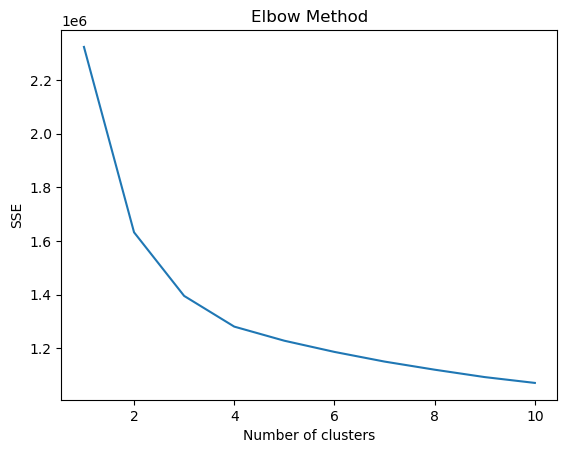

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'odometer',
                                                   'condition']),
                                                 ('cat', OneHotEncoder(),
                                                  ['make', 'model'])])),
                ('cluster', KMeans(n_clusters=10, n_init=10, random_state=0))])

In [20]:
y = car_data['sellingprice']
X = car_data.drop('sellingprice', axis=1)

# Preprocessing
categorical_features = ['make', 'model']
numerical_features = ['year', 'odometer', 'condition']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Elbow Method to determine number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('cluster', kmeans)])
    pipeline.fit(X)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

pipeline.fit(X)

In [21]:
# optimal_k determined based on Elbow method
optimal_k = 4  
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=0)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('cluster', kmeans)])

/Users/lassewillen/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


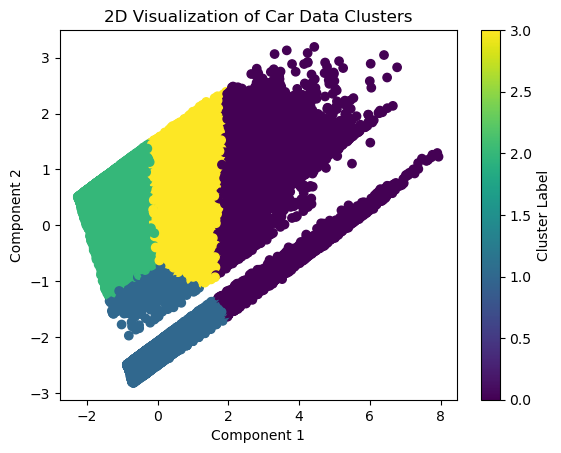

In [22]:
# Prepare the features by dropping the target variable 'sellingprice'
X = car_data.drop('sellingprice', axis=1)

# Define which features are categorical and which are numerical
categorical_features = ['make', 'model']
numerical_features = ['year', 'odometer', 'condition']

# Create a preprocessor that scales numerical features and encodes categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scale numerical features to have mean=0 and variance=1
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Convert categorical features into one-hot vectors
    ])

# Create a pipeline that preprocesses the data and then applies KMeans clustering
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # First, preprocess the data
    ('cluster', KMeans(n_clusters=4, random_state=42))  # Then cluster it into 4 groups
])

# Fit the pipeline to the data
pipeline.fit(X)

# Use TruncatedSVD to reduce the dimensionality of the preprocessed data to 2D for visualization
svd = TruncatedSVD(n_components=2, random_state=42)
X_reduced = svd.fit_transform(pipeline.named_steps['preprocessor'].transform(X))  # Transform the data to 2D

# Visualize the clusters
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=pipeline.named_steps['cluster'].labels_, cmap='viridis')  # Scatter plot of the two principal components colored by cluster
plt.title('2D Visualization of Car Data Clusters')  # Title of the plot
plt.xlabel('Component 1')  # X-axis label
plt.ylabel('Component 2')  # Y-axis label
plt.colorbar(label='Cluster Label')  # Color bar to show cluster labels
plt.show()  # Display the plot